In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
import xesmf as xe
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from matplotlib import gridspec

In [2]:
# Head to google catalog to get some vertical motion data

# Read in data catalog

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


# Control

In [22]:
# Find SST

df_sst_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl' & member_id=='r1i1p1f1'")
#df_sst_control = df_sst_control.drop_duplicates('source_id').head(44)
df_sst_control = df_sst_control.drop_duplicates('source_id')
df_sst_control = df_sst_control[~df_sst_control['source_id'].isin(['MCM-UA-1-0','GISS-E2-1-G-CC','NorESM1-F','IITM-ESM',
                                                                  'GISS-E2-2-G','AWI-ESM-1-1-LR','EC-Earth3-LR',
                                                                  'E3SM-1-1-ECA','MIROC-ES2H','ICON-ESM-LR',
                                                                  'KIOST-ESM','NESM3','KACE-1-0-G','GISS-E2-1-H','MPI-ESM-1-2-HAM',
                                                                  'HadGEM3-GC31-LL','EC-Earth3-Veg','CAS-ESM2-0','FIO-ESM-2-0'])]
#df_sst_control = df_sst_control.drop(index=66921)
#df_sst_control = df_sst_control.drop(index=213497)
#df_sst_control = df_sst_control.drop(index=246458)
#df_sst_control = df_sst_control.drop(index=253865)
#df_sst_control = df_sst_control.drop(index=294959)
#df_sst_control = df_sst_control.drop(index=377491)
#df_sst_control = df_sst_control.drop(index=384507)
#df_sst_control = df_sst_control.drop(index=385525)
#df_sst_control = df_sst_control.drop(index=217984)
#df_sst_control = df_sst_control.drop(index=375351)
#df_sst_control = df_sst_control.append(df.iloc[472969])
print(len(df_sst_control))
df_sst_control

39


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9418,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...,NaN,20180701
18366,CMIP,NOAA-GFDL,GFDL-ESM4,piControl,r1i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...,NaN,20180701
32184,CMIP,NASA-GISS,GISS-E2-1-G,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...,NaN,20180824
40419,CMIP,BCC,BCC-CSM2-MR,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...,NaN,20181016
44330,CMIP,MIROC,MIROC6,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...,NaN,20181212
44600,CMIP,BCC,BCC-ESM1,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...,NaN,20181214
55630,CMIP,MRI,MRI-ESM2-0,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/piControl...,NaN,20190222
67594,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,NaN,20190320
67702,CMIP,NCAR,CESM2-WACCM,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/piContr...,NaN,20190320
90064,CMIP,CCCma,CanESM5,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...,NaN,20190429


In [23]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_ts = []
for zstore in df_sst_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    print(ds.time)
    ds_sel = ds.isel(time=slice(len(ds.time)-3000,len(ds.time)))
    print(ds_sel.time.head(1).values)
    print(ds_sel.time.tail(1).values)
    ds_ts_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_ts = ds_ts_interp.ts
    ds_ts['name'] = name # Creating a new dimension for each ensemble member
    dset_list_ts.append(ds_ts)

GFDL-CM4
<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(151, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(151, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(151, 3, 16, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(650, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(650, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(650, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    calendar_type:  noleap
    description:    for time-mean fields
    long_name:      time
    standard_name:  time
[cftime.DatetimeNoLeap(401, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(650, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
GFDL-ESM4
<xarray.DataArray 'time' (time: 6000)>
array([cftime.Datetim

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'time' (time: 9600)>
array([cftime.DatetimeGregorian(3200, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3200, 2, 15, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3200, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(3999, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3999, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3999, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 3200-01-16 12:00:00 ... 3999-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeGregorian(3750, 1, 16, 12, 0, 0, 0, has_year_zero=False)]
[cftime.DatetimeGregorian(3999, 12, 16, 12, 0, 0, 0, has_year_zero=False)]
BCC-ESM1
<xarray.DataArray 'time' (time: 5412)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0,

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.DataArray 'time' (time: 12000)>
array([cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2849, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2849, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2849, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2849-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2600, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2849, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
MPI-ESM1-2-HR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2349, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2349, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2349, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2100, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2349, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
E3SM-1-0
<xarray.DataArray 'time' (t

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeProlepticGregorian(2401, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2401, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2401, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2900, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2900, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2900, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2401-01-16 12:00:00 ... 2900-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2651, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2900, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
FGOALS-f3-L
<xarray.DataArray 'time'

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeProlepticGregorian(950, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(950, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(950, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(1449, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1449, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1449, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0950-01-16 12:00:00 ... 1449-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(1200, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(1449, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
CESM2-WACCM-FV2
<xarray.DataArray 'time

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

<xarray.DataArray 'time' (time: 6012)>
array([cftime.DatetimeProlepticGregorian(2300, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2300, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2300, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2800, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2800, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2800, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2300-01-16 12:00:00 ... 2800-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2551, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2800, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
EC-Earth3


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


<xarray.DataArray 'time' (time: 6012)>
array([cftime.DatetimeProlepticGregorian(2259, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2259, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2259, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2759, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2759, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2759, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2259-01-16 12:00:00 ... 2759-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2510, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2759, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'time' (time: 14400)>
array([cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1850, 2, 15, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1850, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(3049, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3049, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3049, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 3049-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bounds
    long_name:      Time axis
    standard_name:  time
[cftime.DatetimeGregorian(2800, 1, 16, 12, 0, 0, 0, has_year_zero=False)]
[cftime.DatetimeGregorian(3049, 12, 16, 12, 0, 0, 0, has_year_zero=False)]
CIESM
<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(1, 1, 16, 12, 0, 0

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

<xarray.DataArray 'time' (time: 12000)>
array([cftime.DatetimeProlepticGregorian(101, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(1100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0101-01-16 12:00:00 ... 1100-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(851, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(1100, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
EC-Earth3-CC
<xarray.DataArray 'time' (

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [24]:
ts_control = xr.concat(dset_list_ts, dim='name', coords='minimal', compat='override')
ts_control.load()

<xarray.DataArray 'ts' (name: 39, time: 3000, lat: 88, lon: 179)>
array([[[[242.84971771, 242.66496582, 242.47948456, ..., 243.58927612,
          243.40431213, 243.21939468],
         [243.63949127, 243.44372253, 243.29657745, ..., 244.90614929,
          244.59173203, 244.2774704 ],
         [246.25374451, 245.90968399, 245.56938934, ..., 247.87031631,
          247.43874741, 247.00861588],
         ...,
         [240.82526779, 241.02651901, 241.20874405, ..., 239.58558884,
          239.71549988, 239.87349091],
         [239.01806641, 239.15462875, 239.1531105 , ..., 238.66062698,
          238.73306274, 238.8034462 ],
         [237.19956894, 237.17460861, 237.14242172, ..., 237.29992981,
          237.27476883, 237.249646  ]],

        [[231.19080734, 230.98271408, 230.78353119, ..., 232.02898483,
          231.81859207, 231.60873795],
         [232.5759758 , 232.11302643, 231.76231384, ..., 234.26324005,
          233.81225967, 233.36273651],
         [235.06249237, 234.55499725, 234.08073044, ..., 237.85826569,
          237.20528412, 236.5481102 ],
...
         [252.59700031, 252.89710688, 253.18277567, ..., 250.96788747,
          251.57834489, 251.93443832],
         [251.47553492, 251.63000926, 251.78449822, ..., 250.86185002,
          251.05764086, 251.19390183],
         [250.43064473, 250.46915922, 250.50767451, ..., 250.24815816,
          250.29478923, 250.34143216]],

        [[235.88255857, 235.75679429, 235.63103429, ..., 236.59539711,
          236.40969452, 236.22399193],
         [235.93133072, 235.68662307, 235.44192515, ..., 237.32241488,
          236.9268464 , 236.57758065],
         [238.58421597, 238.05978223, 237.53220096, ..., 240.46987246,
          240.08363551, 239.59210982],
         ...,
         [253.46696183, 253.88567042, 254.27706997, ..., 250.97582524,
          251.83714181, 252.4119334 ],
         [251.4940111 , 251.81559306, 252.13716932, ..., 250.50176832,
          250.80569175, 251.01669927],
         [250.60141325, 250.71503962, 250.82868043, ..., 250.18500417,
          250.28774586, 250.39048754]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U17 'GFDL-CM4' 'GFDL-ESM4' ... 'EC-Earth3-CC'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Temperature
    original_name:  ts
    standard_name:  surface_temperature
    units:          K

In [25]:
ts_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_ts_39model_piControl_2x2_last250.nc')

In [10]:
ts_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_ts_35model_piControl_2x2_250yr.nc')

# Historical

In [7]:
# Find SST

df_sst_historical = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'historical' & member_id=='r1i1p1f1'")
df_sst_historical = df_sst_historical.drop_duplicates('source_id')
df_sst_historical = df_sst_historical[~df_sst_historical['source_id'].isin(['MCM-UA-1-0','GISS-E2-1-G-CC','NorESM1-F','IITM-ESM',
                                                                  'GISS-E2-2-G','AWI-ESM-1-1-LR','EC-Earth3-LR',
                                                                  'E3SM-1-1-ECA','MIROC-ES2H','ICON-ESM-LR',
                                                                 'KIOST-ESM','NESM3','KACE-1-0-G','GISS-E2-1-H','MPI-ESM-1-2-HAM',
                                                                  'HadGEM3-GC31-LL','EC-Earth3-Veg','CAS-ESM2-0','FIO-ESM-2-0',
                                                                    'E3SM-1-0','CMCC-CM2-HR4','IPSL-CM6A-LR-INCA'])]
#df_sst_historical = df_sst_historical.drop(index=29178)
#df_sst_historical = df_sst_historical.drop(index=213982)
#df_sst_historical = df_sst_historical.drop(index=246329)
#df_sst_historical = df_sst_historical.drop(index=253035)
#df_sst_historical = df_sst_historical.drop(index=254276)
#df_sst_historical = df_sst_historical.drop(index=287536)
#df_sst_historical = df_sst_historical.drop(index=383124)
#df_sst_historical = df_sst_historical.drop(index=395017)
#df_sst_historical = df_sst_historical.drop(index=385331)
#df_sst_historical = df_sst_historical.append(df.iloc[440149])
#df_sst_historical = df_sst_historical.append(df.iloc[81594])
#df_sst_historical = df_sst_historical.append(df.iloc[37817])
#df_sst_historical = df_sst_historical.append(df.iloc[375571])
#df_sst_historical = df_sst_historical.append(df.iloc[44185])
#df_sst_historical = df_sst_historical.append(df.iloc[472940])
#df_sst_historical = df_sst_historical.append(df.iloc[394191])
#df_sst_historical = df_sst_historical.append(df.iloc[276810])
#df_sst_historical = df_sst_historical.append(df.iloc[462358])
#df_sst_historical = df_sst_historical.append(df.iloc[453032])
df_sst_historical

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9919,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
29178,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32411,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
43276,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
44597,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20181212
44878,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181214
55742,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190222
56330,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
59848,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
68158,CMIP,SNU,SAM0-UNICON,historical,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historic...,NaN,20190323


In [8]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1980) 
new_time_index
    
dset_list_ts_hist = []
for zstore in df_sst_historical.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    print(ds.time)
    ds_sel = ds.isel(time=slice(0,1980))
    print(ds_sel.time.head(1).values)
    print(ds_sel.time.tail(1).values)
    ds_ts_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_ts = ds_ts_interp.ts
    ds_ts['name'] = name # Creating a new dimension for each ensemble member
    dset_list_ts_hist.append(ds_ts)

GFDL-CM4
<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2014, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    calendar_type:  noleap
    description:    Temporal mean
    long_name:      time
    standard_name:  time
[cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
IPSL-CM6A-LR
<xarray.DataArray 'time' (time: 1980)>
array(['18

<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2014, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
INM-CM5-0
<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       

<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeNoLeap(1850, 1, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 14, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 15, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2014, 10, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 15, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    title:          time
    type:           double
[cftime.DatetimeNoLeap(1850, 1, 15, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(2014, 12, 15, 12, 0, 0, 0, has_year_zero=True)]
GISS-E2-2-H
<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0,

<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2014, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bounds
    long_name:      Time axis
    standard_name:  time
    time_origin:    1850-01-01 00:00:00
[cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
EC-Earth3-CC
<xarray.DataArray 'time' (time: 1980)>
array(['1850-01-16T12:00:00.00000

In [10]:
ts_historical = xr.concat(dset_list_ts_hist, dim='name', coords='minimal', compat='override')
ts_historical.load()

<xarray.DataArray 'ts' (name: 38, time: 1980, lat: 88, lon: 179)>
array([[[[244.52796097, 244.39143524, 244.26848602, ..., 245.07502136,
          244.93811035, 244.80129089],
         [244.8210968 , 244.59099426, 244.44102478, ..., 245.9732048 ,
          245.66452026, 245.35730286],
         [246.57397919, 246.15527267, 245.74406815, ..., 248.70368729,
          248.18502045, 247.66328125],
         ...,
         [239.09574432, 239.38926468, 239.69835281, ..., 237.46035538,
          237.61838913, 237.7977272 ],
         [236.91447601, 237.3062088 , 237.5741272 , ..., 235.93087463,
          236.13482666, 236.3379364 ],
         [236.59933319, 236.66674652, 236.73718262, ..., 236.32486115,
          236.39418411, 236.46306763]],

        [[234.77145309, 234.65384445, 234.55373383, ..., 235.24933014,
          235.12876892, 235.00890121],
         [235.17403259, 234.91886826, 234.81656647, ..., 236.50554123,
          236.1473999 , 235.79184723],
         [237.15524902, 236.77086105, 236.38226318, ..., 239.26166   ,
          238.70205307, 238.14924088],
...
         [271.79909498, 271.78977915, 271.77820841, ..., 271.7377867 ,
          271.77218645, 271.79146823],
         [271.63476902, 271.65205027, 271.66508823, ..., 271.27565562,
          271.47285885, 271.5045561 ],
         [271.2162678 , 271.25455709, 271.27246602, ..., 271.05951752,
          271.08575389, 271.12509288]],

        [[258.2568158 , 258.64799703, 258.69404856, ..., 258.92324921,
          258.97971242, 258.85544871],
         [260.27002479, 259.90351579, 259.61897702, ..., 260.5463974 ,
          259.95954132, 259.99232059],
         [261.60150486, 261.35972198, 261.0110772 , ..., 261.77207235,
          261.69835307, 261.62313039],
         ...,
         [263.60843096, 263.92655334, 264.20646837, ..., 262.6791173 ,
          262.9682707 , 263.20249166],
         [261.75925174, 261.82923126, 261.97933875, ..., 261.21869202,
          261.46522776, 261.54561869],
         [260.52224264, 260.61907918, 260.68627014, ..., 260.23036692,
          260.32479858, 260.36842468]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2015-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U17 'GFDL-CM4' 'IPSL-CM6A-LR' ... 'CMCC-ESM2'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Temperature
    original_name:  ts
    standard_name:  surface_temperature
    units:          K

In [60]:
ts_historical.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_ts_35model_historical_2x2.nc')

In [11]:
ts_historical.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_ts_38model_historical_2x2.nc')

Text(0.5, 0.99, 'Mean TS')

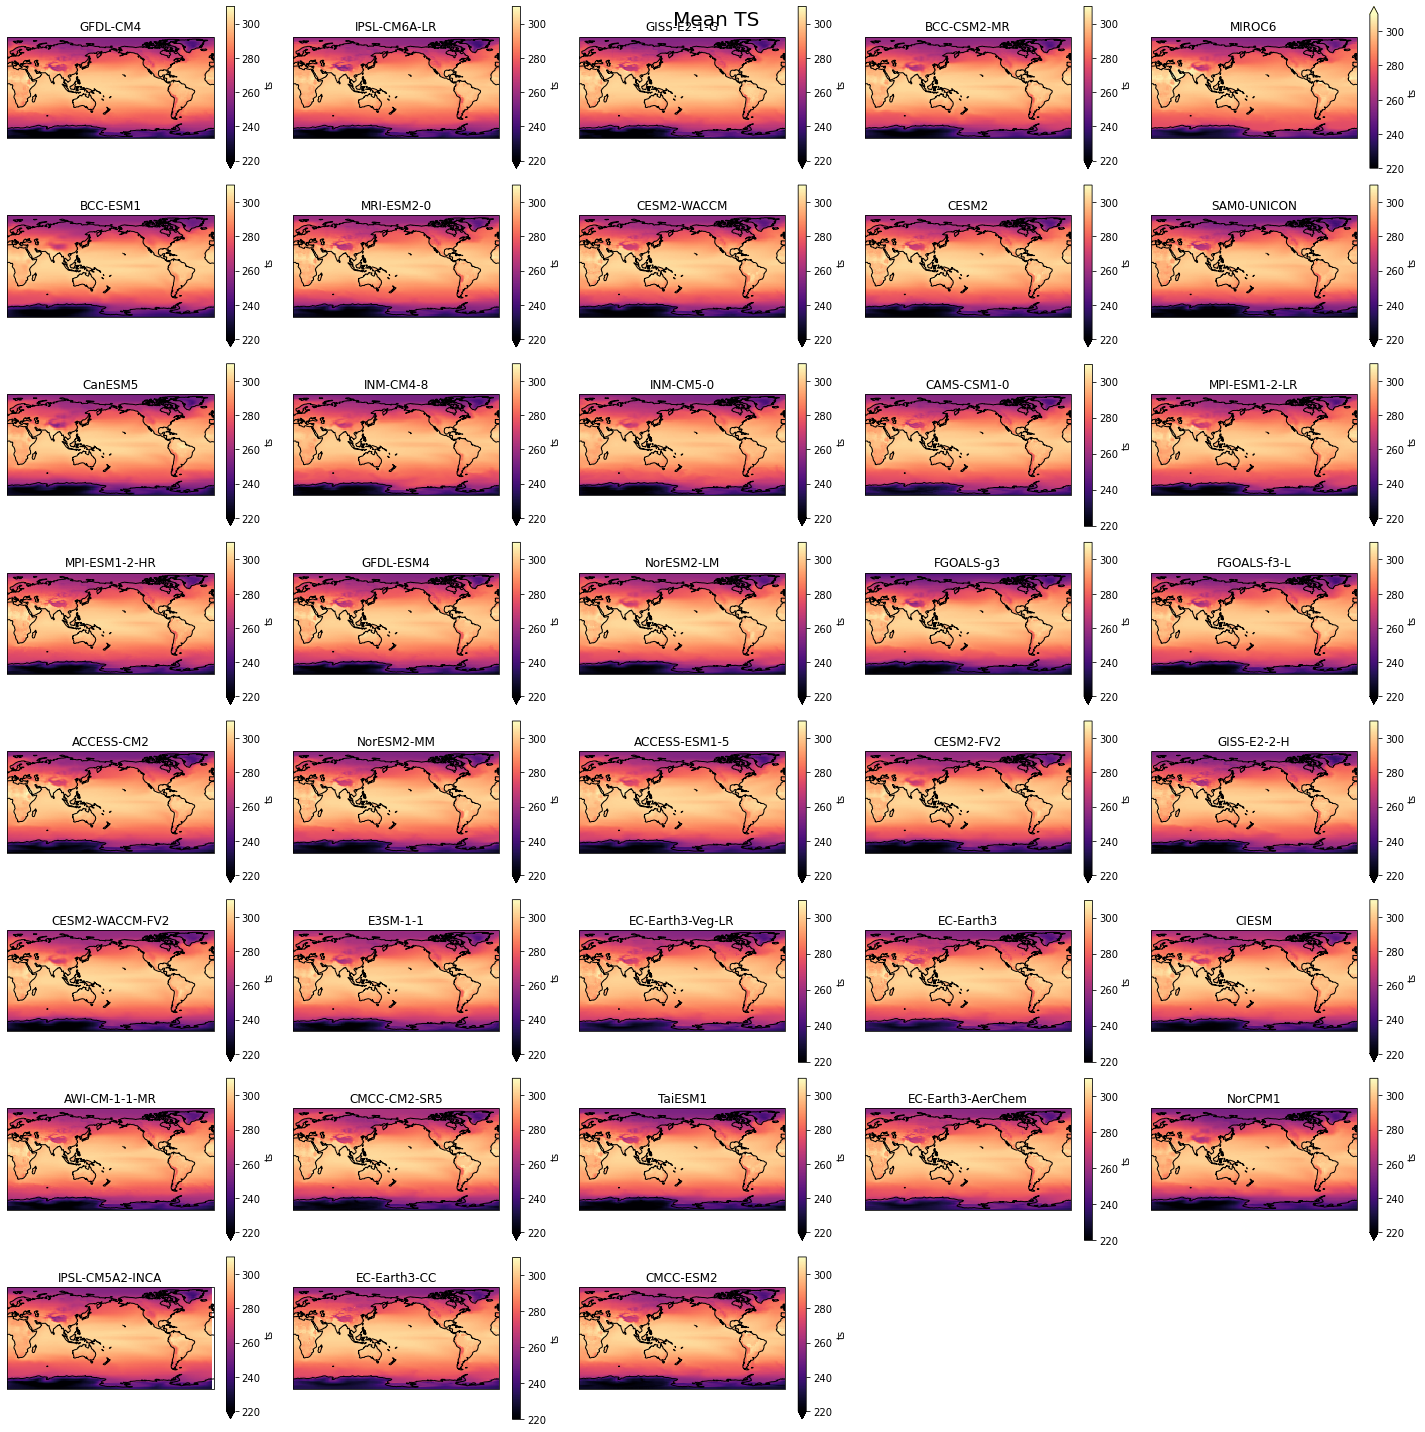

In [16]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in ts_historical['name'].values:
    ax = fig.add_subplot(8,5,i, projection=ccrs.PlateCarree(central_longitude=180))
    ts_historical.sel(name=model).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=220, vmax=310, cmap='magma')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Mean TS', fontsize=20, y=0.99)